In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as web
from functools import reduce
from tabulate import tabulate
from matplotlib.ticker import FormatStrFormatter
import time
import scipy.optimize as sci_opt

## Main purpose of the assignment

Investment/portfolio design and analysis
- Goal of project: Build a portfolio, return and risks evaluation. Estimate a model (CAPM / Multifactors models).
- Introduction: present the companies, assets, benchmarks,…selected.
- Present your data and the selected securities in your portfolio;
- Present your methodology and the materials/sofware used (Gretl, R, Phyton, …).
- Data analysis (risks, return, correlation, …)
- Evaluation of portfolio performance and conclusion.
- Annex: Detailed information about the data collected.


In this report we are going to make an analysis of the healthcare industry, specifically focusing on the pharmaceutical sector to observe how the current global pandemic shaped the evolution of the industry

- Exporting the data from yahoo finance

In [2]:
stocks = {'PFE':'PFIZER INC', 'AZN':'ASTRAZENECA', 'GSK':'GLAXOSMITHKLINE',  'SAN':'SANOFI', 'NVS':'NOVARTIS', 'JNJ':'JOHNSON & JOHNSON', 'BMY':'BRISTOL-MYERS',"ABBV": "ABBVIE INC", "UNH":"UnitedHealth Group Incorporated", "CVS":"CVS Health Corporation", "ANTM": "Anthem, Inc.", "FORTIS.NS": "Fortis Healthcare Limited", "WBA": "Walgreens Boots Alliance, Inc.", "ABT":"Abbott Laboratories", "MDT":"Medtronic plc", "MMM": "3M Company", "SYK": "Stryker Corporation", "BDX": "Becton, Dickinson and Company", "TMO": "Thermo Fisher Scientific Inc.", "BAYN.DE":"Bayer Aktiengesellschaft", "NVO": "Novo Nordisk A/S"     }
funds = {'IHE' : 'ISHARES US PHARMACEUTICALS', 'XBI' :  'SPDR S&P BIOTECH', 'PJP' :  'INVESCO DYNAMIC PHARMACEUTIC', "XLV":"Health Care Select Sector SPDR Fund "}
commodoties = {'GC=F' : "Gold"}
currencies = {"EURUSD%3DX": "EUR/USD Spot Rate", "USDEUR%3DX": "USD/EUR Spot Rate"}
instruments = {**stocks, **funds, **commodoties, **currencies}
tickers = list(instruments.keys())
instruments_data = {}
N = len(tickers)
#index = {'^GSPC' : "S&P 500"}

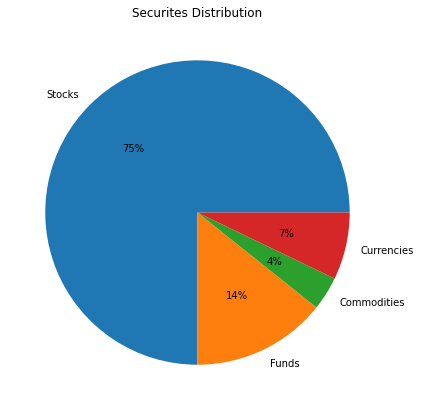

In [3]:
values = [len(stocks), len(funds), len(commodoties), len(currencies)]
labels = ["Stocks", "Funds", "Commodities", "Currencies"]

plt.figure(figsize = (7,7))
plt.pie(values, labels = labels, autopct='%1.0f%%')

plt.title("Securites Distribution")
plt.show()

- We are going to consder data from the following periods

In [4]:
start = datetime.datetime(2015,1,1)
end   = datetime.datetime(2020,12,31)

- Getting instruments based on ticker

In [5]:
instruments_data = {}
for ticker, instrument in instruments.items():
    instruments_data[ticker] = web.DataReader(ticker, data_source = 'yahoo', start = start, end = end)

- Checking a specific security 

In [6]:
instruments_data["NVO"]

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,42.680000,42.250000,42.549999,42.490002,713200.0,36.274506
2015-01-05,42.669998,42.259998,42.599998,42.410000,1134700.0,36.206219
2015-01-06,42.549999,41.720001,42.250000,41.900002,1057300.0,35.770821
2015-01-07,42.290001,41.820000,42.230000,42.209999,1616200.0,36.035465
2015-01-08,43.040001,42.540001,42.599998,42.840000,1520800.0,36.573311
...,...,...,...,...,...,...
2020-12-24,69.879997,69.330002,69.779999,69.430000,277500.0,68.453140
2020-12-28,71.459999,69.940002,71.459999,70.250000,1256600.0,69.261604
2020-12-29,71.190002,70.389999,71.190002,70.580002,1274400.0,69.586967


- Keeping only the adjusted close price

In [7]:
for ticker, instrument in instruments.items():
  instruments_data[ticker] = instruments_data[ticker]["Adj Close"]

- Checking trading days

In [8]:
tr_days = [ len(instr) for _, instr in instruments_data.items() ] 
tr_days = pd.DataFrame(tr_days, index = tickers, columns = ["Trading Days"])
tr_days.T

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Trading Days,1511,1511,1511,1511,1511,1511,1511,1511,1511,1511,...,1511,1519,1511,1511,1511,1511,1511,1582,1564,1564


In [9]:
## Merging Dataframes
data = list(instruments_data.values())
data_df = reduce(lambda x, y: pd.merge(x, y, left_index = True, right_index = True, how = 'outer'), data).dropna()
data_df.columns = tickers

In [10]:
data_df

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,23.582064,25.775995,30.548771,6.549814,64.720291,88.150795,49.982468,49.825306,91.329041,81.299774,...,125.486465,92.285164,36.274506,139.506882,61.828773,60.398533,61.841980,1186.000000,1.208941,0.82717
2015-01-05,23.454107,25.578283,30.217108,6.168649,64.860603,87.535149,49.201370,48.887630,89.824738,80.496178,...,123.762657,89.181412,36.206219,138.588684,62.022408,60.008694,61.526585,1203.900024,1.194643,0.83707
2015-01-06,23.649807,24.955854,30.051291,6.051967,64.313377,87.104996,49.117378,48.645649,89.643463,80.556015,...,122.606903,90.202171,35.770821,137.799179,60.480042,59.655113,61.319359,1219.300049,1.193902,0.83759
2015-01-07,23.973467,24.930222,30.361315,6.145313,64.594002,89.027946,49.755703,50.611748,90.558754,82.009331,...,126.279808,90.202171,36.035465,140.773804,62.898590,61.033165,62.761097,1210.599976,1.187536,0.84208
2015-01-08,24.462721,25.289038,31.139986,5.717474,66.839050,89.727943,50.998749,51.141083,94.881439,83.753311,...,127.592308,95.102600,36.573311,143.261917,64.293289,62.329624,63.833408,1208.400024,1.183600,0.84488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,36.344620,47.805977,35.459026,3.040000,84.777702,151.773575,60.472191,101.611565,333.824036,66.773354,...,464.931519,48.240002,69.626404,175.649033,151.088333,69.605919,110.685837,1866.599976,1.223691,0.81720
2020-12-23,37.037083,47.845219,35.596581,3.150000,84.969978,150.998413,60.048893,102.086014,336.394897,67.558105,...,458.075470,48.180000,68.640472,176.137253,151.098328,70.144875,110.765564,1874.699951,1.218665,0.82057
2020-12-28,36.423756,48.443653,35.655533,3.140000,87.681175,152.240677,60.167023,102.254044,344.725311,67.627640,...,460.464111,48.580002,69.261604,176.147217,146.419617,70.244682,111.363487,1877.199951,1.220510,0.81933


- Ajudsted Close Evolution for each stock

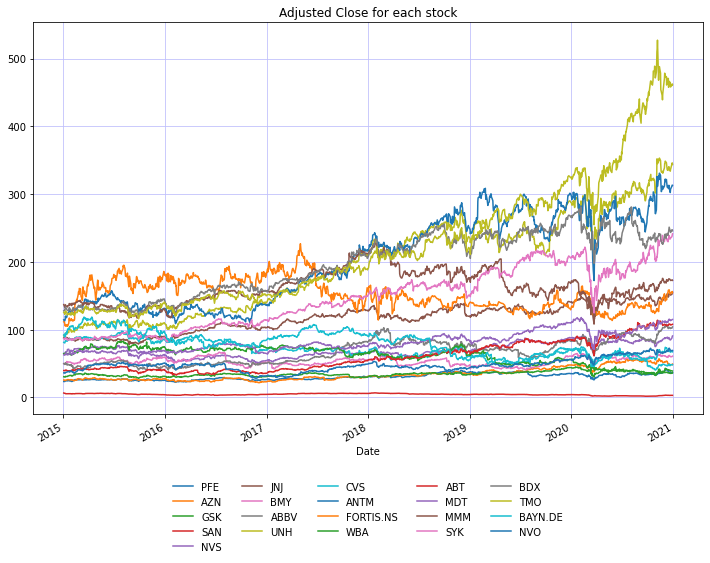

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["PFE","AZN","GSK","SAN","NVS","JNJ","BMY","ABBV", "UNH", "CVS", "ANTM", "FORTIS.NS", "WBA", "ABT", "MDT", "MMM", "SYK", "BDX", "TMO", "BAYN.DE", "NVO"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each stock')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each stock

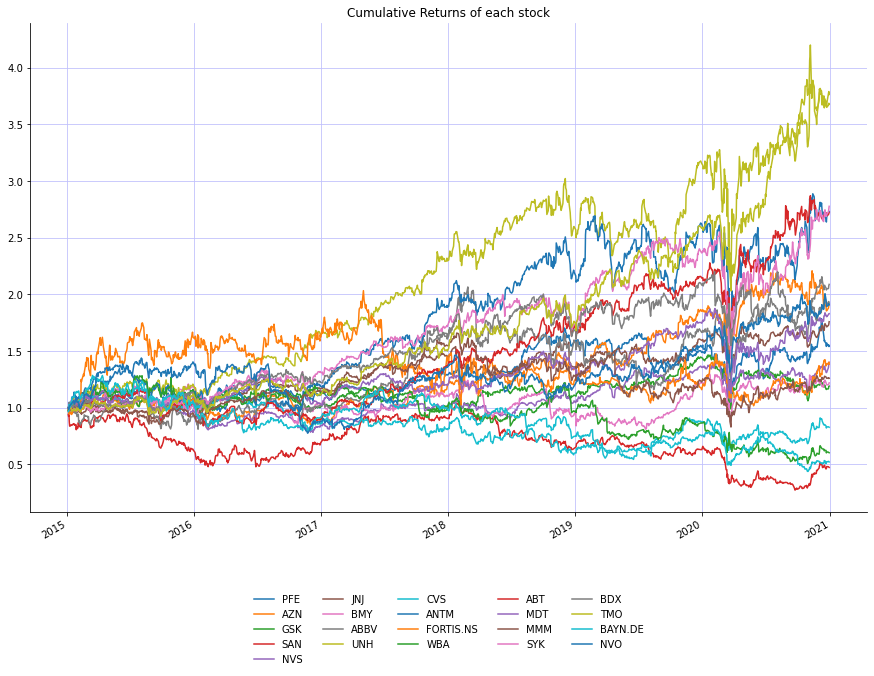

In [12]:
returns = data_df[["PFE","AZN","GSK","SAN","NVS","JNJ","BMY","ABBV", "UNH", "CVS", "ANTM", "FORTIS.NS", "WBA", "ABT", "MDT", "MMM", "SYK", "BDX", "TMO", "BAYN.DE", "NVO"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each stock', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each fund

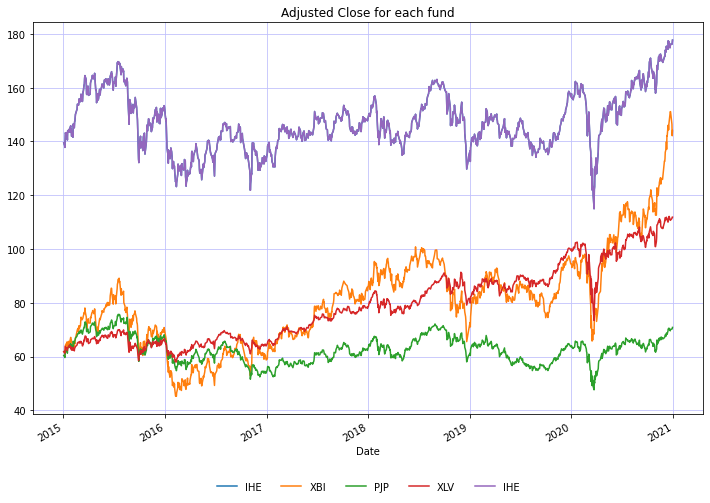

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["IHE","XBI","PJP", "XLV", "IHE"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each fund')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each fund

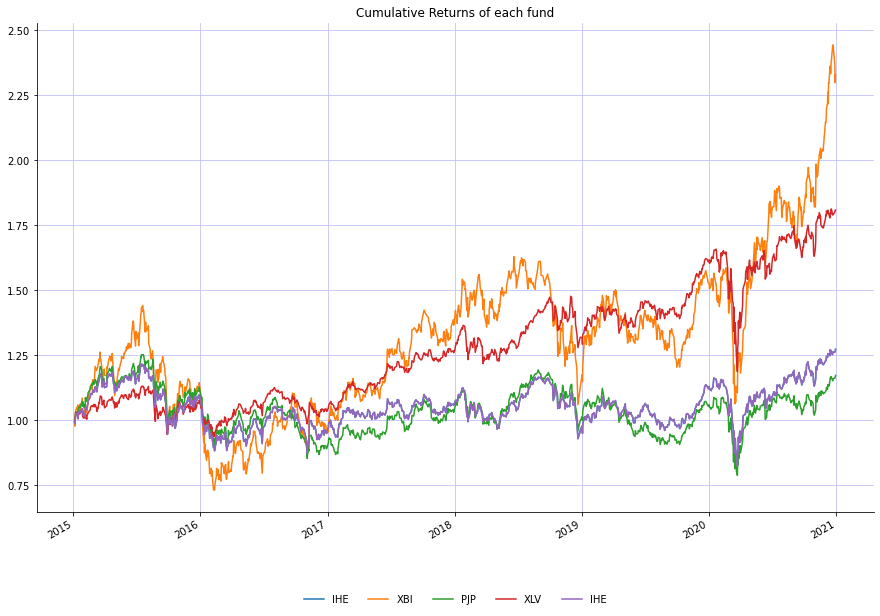

In [14]:
returns = data_df[["IHE","XBI","PJP", "XLV", "IHE"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each fund', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each commodity

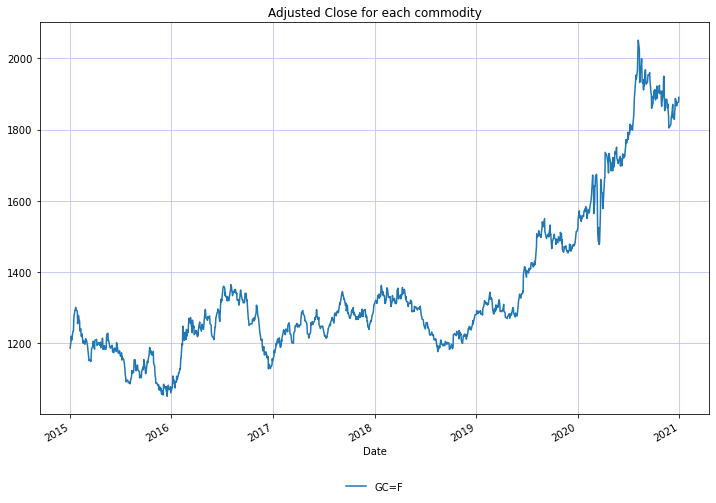

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["GC=F"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each commodity')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each commodity

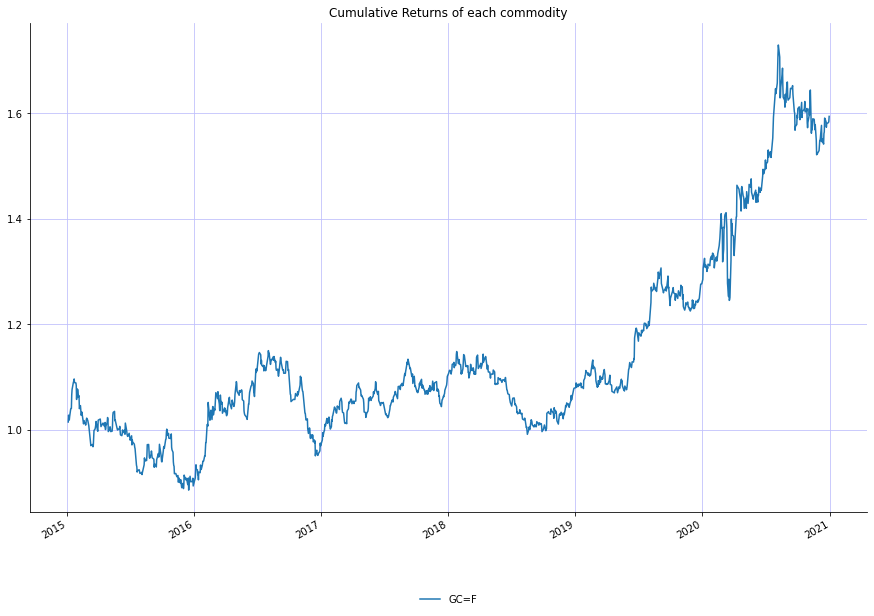

In [16]:
returns = data_df[["GC=F"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each commodity', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

- Adjusted Close Evolution for each currency

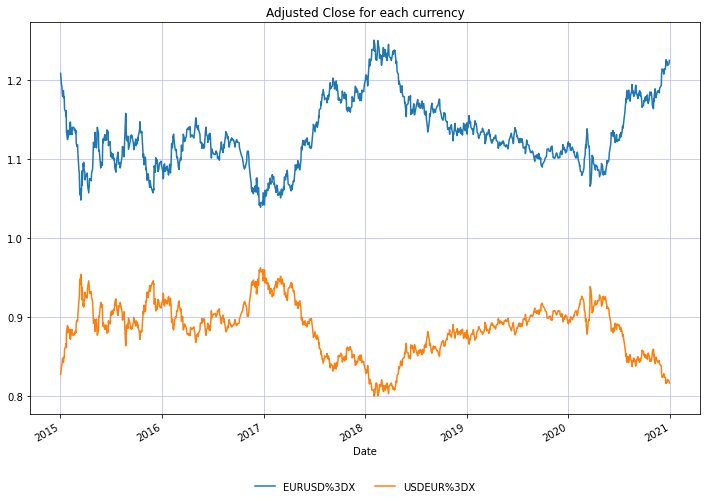

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
data_df[["EURUSD%3DX","USDEUR%3DX"]].plot(ax = plt.gca(),grid = True)
ax.set_title('Adjusted Close for each currency')
ax.grid(c = (0.75, 0.75, 0.99))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)

- Cummulative Returns for each currency

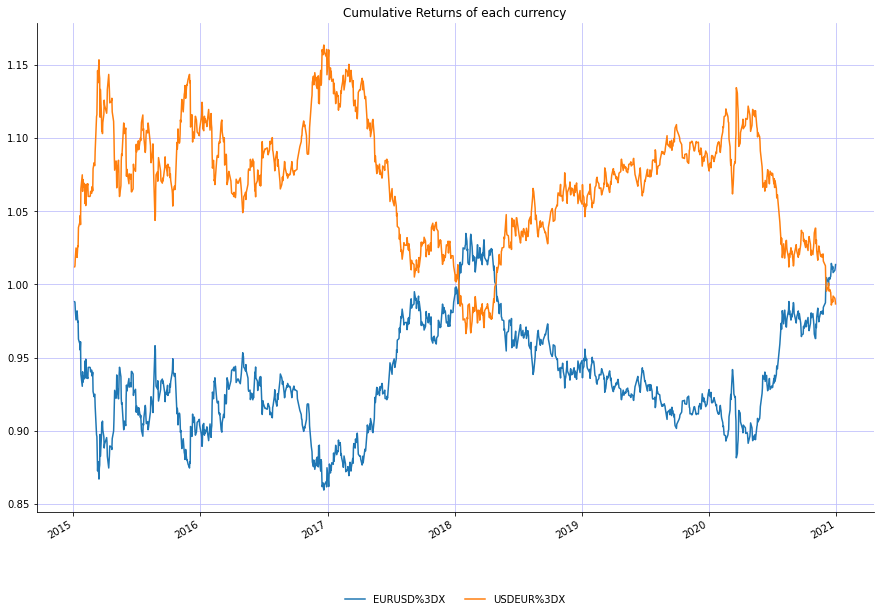

In [18]:
returns = data_df[["EURUSD%3DX","USDEUR%3DX"]] .apply(np.log).diff(1) 
cumulative_returns = returns.cumsum().apply(np.exp)
ax = cumulative_returns.plot(title='Cumulative Returns of each currency', figsize=(15,10));
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('')
ax.grid(c = (0.75, 0.75, 0.99))
plt.show()

## Calculate Descriptive Statistics

In order to calculate the returns for each of these securities we need to consider:

Simple Returns: weighted sum of the simple returns of the securities of the portfolio.

$$r_t = \frac{P_t}{P_0} - 1$$

Log Retruns: The log return for a time period is the sum of the log returns of partitions of the time period.  

$$r_t = ln\left(\frac{P_t}{P_0}\right)$$

For this analysis we considered log returns since the frequency of compounding does not matter, making returns of different assets easier to compare. 

- Log Returns (daily)

In [19]:
returns = data_df.pct_change()
returns

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.005426,-0.007670,-0.010857,-0.058195,0.002168,-0.006984,-0.015627,-0.018819,-0.016471,-0.009884,...,-0.013737,-0.033632,-0.001883,-0.006582,0.003132,-0.006454,-0.005100,0.015093,-0.011827,0.011968
2015-01-06,0.008344,-0.024334,-0.005488,-0.018915,-0.008437,-0.004914,-0.001707,-0.004950,-0.002018,0.000743,...,-0.009338,0.011446,-0.012026,-0.005697,-0.024868,-0.005892,-0.003368,0.012792,-0.000621,0.000621
2015-01-07,0.013686,-0.001027,0.010317,0.015424,0.004363,0.022076,0.012996,0.040417,0.010210,0.018041,...,0.029957,0.000000,0.007398,0.021587,0.039989,0.023100,0.023512,-0.007135,-0.005332,0.005361
2015-01-08,0.020408,0.014393,0.025647,-0.069620,0.034756,0.007863,0.024983,0.010459,0.047733,0.021266,...,0.010394,0.054327,0.014925,0.017675,0.022174,0.021242,0.017086,-0.001817,-0.003314,0.003325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.017121,-0.019122,-0.003589,0.009967,-0.003165,-0.001961,-0.009353,-0.008774,-0.003184,-0.021685,...,0.005012,0.030439,-0.017802,0.004559,0.008542,-0.002289,-0.003052,-0.006705,0.001701,-0.001698
2020-12-23,0.019053,0.000821,0.003879,0.036184,0.002268,-0.005107,-0.007000,0.004669,0.007701,0.011752,...,-0.014746,-0.001244,-0.014160,0.002780,0.000066,0.007743,0.000720,0.004339,-0.004107,0.004124
2020-12-28,-0.016560,0.012508,0.001656,-0.003175,0.031908,0.008227,0.001967,0.001646,0.024764,0.001029,...,0.005215,0.008302,0.009049,0.000057,-0.030965,0.001423,0.005398,0.001334,0.001513,-0.001511


- Log Returns (year)

In [20]:
returns_year = data_df.resample('Y').ffill().pct_change()
returns_year

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-31,0.029262,-0.171333,-0.013271,0.100399,-0.135405,0.141512,-0.143995,0.087638,0.369185,-0.186376,...,-0.008227,-0.121810,-0.372543,-0.126972,-0.162345,-0.201253,-0.036317,0.084803,-0.032276,0.033352
2017-12-31,0.159019,0.332417,-0.029457,0.311432,0.194629,0.244252,0.077089,0.600749,0.398350,-0.057523,...,0.350261,0.075094,0.542264,0.106402,0.437725,0.152968,0.217729,0.135913,0.129209,-0.114425
2018-12-31,0.228458,0.132331,0.135602,-0.291477,0.052662,-0.064400,-0.146385,-0.021060,0.132000,-0.075045,...,0.175023,-0.391704,-0.123375,-0.089049,-0.172373,-0.030847,0.047320,-0.020210,-0.042764,0.044674
2019-12-31,-0.060645,0.368442,0.296232,-0.016705,0.277649,0.173850,0.294119,0.041500,0.213529,0.169177,...,0.465034,0.259589,0.290314,0.164284,0.352025,0.055323,0.219921,0.183296,-0.021761,0.022245
2020-12-31,0.036420,0.032031,-0.173386,-0.249395,0.034206,0.103182,0.001559,0.255057,0.193356,-0.051516,...,0.423954,-0.307869,0.242633,0.134263,0.523693,0.112287,0.123373,0.248597,0.095745,-0.087379


- Plotting the log returns evolution according to each thicker (daily)

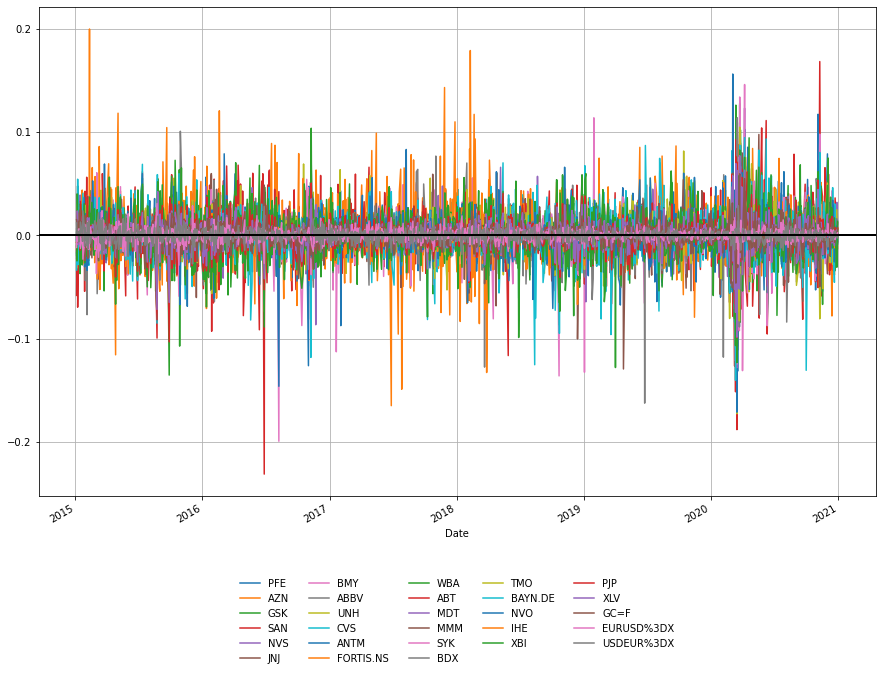

In [21]:
returns.plot(grid = True, figsize = (15,10)).axhline(y = 0, color = "black", lw = 2)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5).get_frame().set_linewidth(0.0)
plt.show()

- Measuring the volatility

Variance $\sigma^2$$$Var(R) = \sigma^2 = \frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}$$
Standard Deviation $\sigma$$$\sigma =\sqrt{\sigma^2} = \sqrt{\frac{\sum_{t = 1}^{N}(R_t - \bar{R_t})^2}{N}}$$where $R_t = $ log price of instrument $i$ at the time $t$

In [22]:
STD = returns.groupby([returns.index.year]).agg('std') * np.sqrt(N) ## per year
STD_avg = STD.mean()

In [23]:
VAR = STD **0.5
VAR_avg = VAR.mean()

In [24]:
VAR

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015,0.276403,0.292714,0.276369,0.334079,0.266968,0.245652,0.297420,0.330015,0.309676,0.273314,...,0.283533,0.336312,0.302281,0.291532,0.365637,0.303753,0.266610,0.228416,0.208264,0.208280
2016,0.268240,0.304322,0.262658,0.412377,0.267403,0.227758,0.338091,0.321496,0.263476,0.285776,...,0.280098,0.308642,0.334721,0.293649,0.378900,0.284657,0.238436,0.246658,0.177000,0.177038
2017,0.200898,0.300506,0.220349,0.290371,0.224577,0.205560,0.286626,0.257980,0.228485,0.288554,...,0.249641,0.253496,0.286498,0.216579,0.283457,0.226868,0.178023,0.195648,0.165904,0.165616
2018,0.260378,0.263759,0.268654,0.318417,0.258024,0.278815,0.318132,0.349751,0.290117,0.324481,...,0.286383,0.329629,0.297800,0.259294,0.338910,0.268333,0.248232,0.198000,0.167176,0.167262
2019,0.268938,0.279313,0.225148,0.303110,0.239736,0.246036,0.307429,0.323380,0.298255,0.306836,...,0.285233,0.336096,0.273290,0.238490,0.313260,0.248022,0.220097,0.211107,0.138999,0.138960
2020,0.358858,0.352461,0.335671,0.466983,0.320179,0.326727,0.328024,0.352339,0.415524,0.372274,...,0.364769,0.389522,0.336543,0.321548,0.384101,0.329270,0.330167,0.278292,0.164175,0.164319


In [25]:
STD

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015,0.076399,0.085682,0.076380,0.111609,0.071272,0.060345,0.088459,0.108910,0.095900,0.074701,...,0.080391,0.113106,0.091374,0.084991,0.133690,0.092266,0.071081,0.052174,0.043374,0.043380
2016,0.071953,0.092612,0.068989,0.170055,0.071505,0.051874,0.114305,0.103360,0.069420,0.081668,...,0.078455,0.095260,0.112038,0.086230,0.143565,0.081030,0.056852,0.060840,0.031329,0.031342
2017,0.040360,0.090304,0.048554,0.084315,0.050435,0.042255,0.082155,0.066554,0.052205,0.083264,...,0.062320,0.064260,0.082081,0.046906,0.080348,0.051469,0.031692,0.038278,0.027524,0.027429
2018,0.067797,0.069569,0.072175,0.101390,0.066576,0.077738,0.101208,0.122325,0.084168,0.105288,...,0.082015,0.108655,0.088685,0.067233,0.114860,0.072003,0.061619,0.039204,0.027948,0.027977
2019,0.072327,0.078016,0.050691,0.091876,0.057473,0.060534,0.094512,0.104574,0.088956,0.094148,...,0.081358,0.112960,0.074687,0.056877,0.098132,0.061515,0.048443,0.044566,0.019321,0.019310
2020,0.128779,0.124228,0.112675,0.218073,0.102515,0.106751,0.107600,0.124143,0.172660,0.138588,...,0.133057,0.151727,0.113261,0.103393,0.147533,0.108419,0.109010,0.077446,0.026953,0.027001


In [26]:
pd.DataFrame(STD_avg, columns = ['Average STD']).T #### Average Volatility

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Average STD,0.076269,0.090068,0.071577,0.129553,0.069963,0.066583,0.09804,0.104978,0.093885,0.096276,...,0.086266,0.107661,0.093688,0.074272,0.119688,0.077783,0.063116,0.052085,0.029408,0.029406


- Covariance Matrix

In [27]:
cov_matrix = round(returns.cov(),6)
cov_matrix

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
PFE,0.000234,0.000106,0.000111,0.000144,0.000110,0.000119,0.000136,0.000150,0.000150,0.000138,...,0.000133,0.000089,0.000107,0.000154,0.000173,0.000156,0.000146,-0.000003,0.000000,-0.000001
AZN,0.000106,0.000302,0.000150,0.000115,0.000134,0.000097,0.000127,0.000130,0.000125,0.000102,...,0.000121,0.000109,0.000146,0.000136,0.000178,0.000141,0.000122,0.000007,0.000005,-0.000005
GSK,0.000111,0.000150,0.000201,0.000152,0.000121,0.000097,0.000112,0.000121,0.000127,0.000109,...,0.000108,0.000111,0.000117,0.000125,0.000140,0.000128,0.000118,0.000011,0.000005,-0.000006
SAN,0.000144,0.000115,0.000152,0.000689,0.000144,0.000110,0.000140,0.000171,0.000199,0.000177,...,0.000160,0.000237,0.000126,0.000174,0.000227,0.000185,0.000166,-0.000020,0.000019,-0.000019
NVS,0.000110,0.000134,0.000121,0.000144,0.000185,0.000089,0.000103,0.000121,0.000125,0.000101,...,0.000113,0.000103,0.000123,0.000126,0.000161,0.000130,0.000117,0.000007,0.000004,-0.000004
JNJ,0.000119,0.000097,0.000097,0.000110,0.000089,0.000175,0.000110,0.000117,0.000130,0.000110,...,0.000123,0.000082,0.000086,0.000121,0.000114,0.000117,0.000126,0.000004,0.000002,-0.000002
BMY,0.000136,0.000127,0.000112,0.000140,0.000103,0.000110,0.000347,0.000173,0.000149,0.000120,...,0.000139,0.000101,0.000129,0.000171,0.000210,0.000174,0.000150,-0.000001,0.000002,-0.000002
ABBV,0.000150,0.000130,0.000121,0.000171,0.000121,0.000117,0.000173,0.000406,0.000172,0.000145,...,0.000154,0.000103,0.000127,0.000173,0.000247,0.000192,0.000173,-0.000014,0.000001,-0.000002
UNH,0.000150,0.000125,0.000127,0.000199,0.000125,0.000130,0.000149,0.000172,0.000369,0.000191,...,0.000165,0.000118,0.000125,0.000170,0.000215,0.000178,0.000187,0.000002,-0.000000,0.000000
CVS,0.000138,0.000102,0.000109,0.000177,0.000101,0.000110,0.000120,0.000145,0.000191,0.000347,...,0.000125,0.000103,0.000110,0.000138,0.000151,0.000148,0.000144,-0.000002,-0.000000,0.000000


In [28]:
Correlation = returns.corr().style.background_gradient(cmap='Blues')
Correlation

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,ANTM,FORTIS.NS,WBA,ABT,MDT,MMM,SYK,BDX,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
PFE,1.000000,0.399093,0.513162,0.358654,0.528485,0.587176,0.478832,0.486843,0.511535,0.483441,0.477173,0.078548,0.439924,0.550555,0.498867,0.444639,0.469977,0.492365,0.514581,0.277688,0.389391,0.693324,0.488684,0.672738,0.746168,-0.019625,0.005219,-0.006511
AZN,0.399093,1.000000,0.608373,0.252731,0.568314,0.421630,0.391918,0.372601,0.373249,0.314928,0.351789,0.079449,0.247109,0.450498,0.342150,0.276160,0.326357,0.340886,0.412208,0.300252,0.467086,0.536848,0.442288,0.533845,0.548963,0.037654,0.045722,-0.046323
GSK,0.513162,0.608373,1.000000,0.410097,0.627966,0.520165,0.426391,0.425223,0.466120,0.413026,0.432071,0.119572,0.335621,0.519064,0.459064,0.389916,0.432415,0.459149,0.452633,0.375395,0.457708,0.607396,0.426243,0.594212,0.651690,0.076222,0.066780,-0.067793
SAN,0.358654,0.252731,0.410097,1.000000,0.403407,0.317492,0.286252,0.323954,0.394563,0.362726,0.381251,0.113184,0.394377,0.370500,0.457387,0.483828,0.406264,0.313453,0.360450,0.430089,0.267291,0.455463,0.373710,0.465600,0.492482,-0.074377,0.127338,-0.128605
NVS,0.528485,0.568314,0.627966,0.403407,1.000000,0.495303,0.406266,0.440436,0.478428,0.398183,0.432409,0.108011,0.354231,0.563696,0.498652,0.400722,0.459422,0.445394,0.493426,0.362412,0.501797,0.634797,0.512707,0.629701,0.673518,0.052835,0.051713,-0.053065
JNJ,0.587176,0.421630,0.520165,0.317492,0.495303,1.000000,0.446342,0.438523,0.511493,0.446986,0.428396,0.093504,0.440127,0.614092,0.528348,0.500550,0.535154,0.538745,0.553409,0.294936,0.363469,0.630674,0.373126,0.585508,0.742099,0.032261,0.030969,-0.031933
BMY,0.478832,0.391918,0.426391,0.286252,0.406266,0.446342,1.000000,0.460777,0.416288,0.346396,0.386455,0.131593,0.298354,0.453680,0.423171,0.325341,0.378586,0.376604,0.442289,0.257842,0.384442,0.631607,0.488430,0.616745,0.627984,-0.006239,0.014061,-0.014908
ABBV,0.486843,0.372601,0.425223,0.323954,0.440436,0.438523,0.460777,1.000000,0.444669,0.386691,0.424457,0.083003,0.320691,0.502036,0.454650,0.393103,0.444763,0.416275,0.454550,0.242824,0.351544,0.589340,0.529934,0.627628,0.669444,-0.067808,0.012038,-0.013199
UNH,0.511535,0.373249,0.466120,0.394563,0.478428,0.511493,0.416288,0.444669,1.000000,0.532931,0.804543,0.125889,0.410915,0.581251,0.551496,0.473752,0.534027,0.488208,0.508287,0.292786,0.362935,0.609372,0.483137,0.609008,0.761742,0.010169,-0.001381,0.000248
CVS,0.483441,0.314928,0.413026,0.362726,0.398183,0.446986,0.346396,0.386691,0.532931,1.000000,0.471180,0.015225,0.623580,0.442649,0.424700,0.403126,0.391872,0.421584,0.396239,0.262492,0.328583,0.508315,0.350423,0.524689,0.602252,-0.010911,-0.003169,0.002892


#### Portfolio Optimization

- Which securities are we going to choose?

- Creating 1000 random portfolios

In [29]:
stocks = {'PFE':'PFIZER INC', 'AZN':'ASTRAZENECA', 'GSK':'GLAXOSMITHKLINE',  'SAN':'SANOFI', 'NVS':'NOVARTIS'  }
funds = {'IHE' : 'ISHARES US PHARMACEUTICALS', 'XBI' :  'SPDR S&P BIOTECH', 'PJP' :  'INVESCO DYNAMIC PHARMACEUTIC', "XLV":"Health Care Select Sector SPDR Fund "}
commodoties = {'GC=F' : "Gold"}
currencies = {"EURUSD%3DX": "EUR/USD Spot Rate", "USDEUR%3DX": "USD/EUR Spot Rate"}
instruments = {**stocks}
tickers = list(instruments.keys())
instruments_data = {}
N = len(tickers)
#index = {'^GSPC' : "S&P 500"}

In [30]:
returns = data_df.pct_change()
returns

,PFE,AZN,GSK,SAN,NVS,JNJ,BMY,ABBV,UNH,CVS,...,TMO,BAYN.DE,NVO,IHE,XBI,PJP,XLV,GC=F,EURUSD%3DX,USDEUR%3DX
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.005426,-0.007670,-0.010857,-0.058195,0.002168,-0.006984,-0.015627,-0.018819,-0.016471,-0.009884,...,-0.013737,-0.033632,-0.001883,-0.006582,0.003132,-0.006454,-0.005100,0.015093,-0.011827,0.011968
2015-01-06,0.008344,-0.024334,-0.005488,-0.018915,-0.008437,-0.004914,-0.001707,-0.004950,-0.002018,0.000743,...,-0.009338,0.011446,-0.012026,-0.005697,-0.024868,-0.005892,-0.003368,0.012792,-0.000621,0.000621
2015-01-07,0.013686,-0.001027,0.010317,0.015424,0.004363,0.022076,0.012996,0.040417,0.010210,0.018041,...,0.029957,0.000000,0.007398,0.021587,0.039989,0.023100,0.023512,-0.007135,-0.005332,0.005361
2015-01-08,0.020408,0.014393,0.025647,-0.069620,0.034756,0.007863,0.024983,0.010459,0.047733,0.021266,...,0.010394,0.054327,0.014925,0.017675,0.022174,0.021242,0.017086,-0.001817,-0.003314,0.003325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.017121,-0.019122,-0.003589,0.009967,-0.003165,-0.001961,-0.009353,-0.008774,-0.003184,-0.021685,...,0.005012,0.030439,-0.017802,0.004559,0.008542,-0.002289,-0.003052,-0.006705,0.001701,-0.001698
2020-12-23,0.019053,0.000821,0.003879,0.036184,0.002268,-0.005107,-0.007000,0.004669,0.007701,0.011752,...,-0.014746,-0.001244,-0.014160,0.002780,0.000066,0.007743,0.000720,0.004339,-0.004107,0.004124
2020-12-28,-0.016560,0.012508,0.001656,-0.003175,0.031908,0.008227,0.001967,0.001646,0.024764,0.001029,...,0.005215,0.008302,0.009049,0.000057,-0.030965,0.001423,0.005398,0.001334,0.001513,-0.001511


In [31]:
l = data_df[["PFE","AZN","GSK","SAN","NVS"]]

In [32]:
len(instruments)

5

In [33]:
def portfolio_simulation(assets, iterations):
    start = time.time()
    num_assets = len(instruments)
    
    # Fetch data    
    df = instruments_data
    port_returns = []
    port_vols = []
    port_weights = []
    sharp_ratio = []
    
    # Weights
    
    for i in range (iterations):
        weights = np.random.dirichlet(np.ones(num_assets),size=1)
        weights = weights[0]
        port_returns.append(np.sum(returns.mean() * weights) * 252)
        port_vols.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
        port_weights.append(weights)
        sharp_ratio = np.array(port_returns) / np.array(port_vols)
    
    # Convert lists to arrays
    
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)

    
    # Plot the distribution of portfolio returns and volatilities
    
    plt.figure(figsize = (20,10))
    plt.scatter(port_vols,port_returns,c = (port_returns / port_vols), marker='o')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')
    
    print('Elapsed Time: %.2f seconds' % (time.time() - start))
    
    return port_returns, port_vols, port_weights, sharp_ratio

- The Markowitz Bullet

In [34]:
port_returns, port_vols, port_weights, sharp_ratio = portfolio_simulation(instruments, 1000) ### Simulations

ValueError: operands could not be broadcast together with shapes (28,) (5,) 

In [ ]:
data = {'Returns':port_returns, 'Volatility':port_vols, "Sharp Ratio": sharp_ratio}

for counter, symbol in enumerate(l.columns.tolist()):
    data[symbol +' Weight'] = [w[counter] for w in port_weights]

In [ ]:
portfolios = pd.DataFrame(data)
portfolios

In [ ]:
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []
list_tickers = ["PFE","AZN","GSK","SAN","NVS"]
num_assets = len(returns.columns)
num_portfolios = 50000

annual_rtns = returns.mean() * 252

cov_daily = returns.cov()
cov_annual = cov_daily * 252
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, annual_rtns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

for counter, symbol in enumerate(list_tickers):
    portfolio[symbol+' weight'] = [weight[counter] for weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)
    
# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' weight' for stock in list_tickers]
# reorder dataframe columns
df = df[column_order]

In [ ]:
df

In [ ]:
max_sharpe_row_ = df.iloc[df['Sharpe Ratio'].idxmax()]
max_sharpe_RTN = max_sharpe_row_['Returns']
max_sharpe_VOL = max_sharpe_row_['Volatility']
min_vol_row_ = df.iloc[df['Volatility'].idxmin()]
min_vol_RTN = min_vol_row_['Returns']
min_vol_VOL = min_vol_row_['Volatility']
plt.figure(figsize=(12,8))
plt.scatter(port_volatility, port_returns, c=sharpe_ratio,
                  cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_VOL, max_sharpe_RTN, c='red', s=50) # red dot
plt.scatter(min_vol_VOL, min_vol_RTN, c='blue', s=50) # red dot
plt.title('Efficient Frontier')
plt.show()

In [ ]:
returns